In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from get_image_dataset import get_dataloader, get_label
from PIL import Image
from torchvision import transforms as T
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
train, test = get_dataloader('normalized_red_quantized', patch_size=12, batch_size=1000)

/Users/jackylei/Documents/Semiconductors/Playground/get_image_dataset.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  label_dist = nn.functional.softmax(nn.functional.one_hot(label_tensor, num_classes=6).to(torch.float32))


In [4]:
class ClusteringLayer(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        self.n_classes = n_classes 
        self.alpha = 1.0
        self.weights = nn.Parameter(torch.randn((self.n_classes, self.n_classes)))
    def forward(self,x):
        assert x.shape[1] == self.n_classes
        q = 1.0 / (1.0 + torch.sqrt(torch.sum(torch.square(torch.unsqueeze(x, 1) - self.weights), dim=2)) ** 2 / self.alpha)
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = torch.transpose(torch.transpose(q,0,1)/torch.sum(q,dim=1),0,1)
        return q

In [5]:
class SSLDEC(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
        self.size = (64,128,256)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,self.size[0],(3,3), 1, 'same'),
            nn.BatchNorm2d(self.size[0]),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[0],self.size[0],(3,3), 1, 'same'),
            nn.BatchNorm2d(self.size[0]),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[0],self.size[0],(3,3), 1, 'same'),
            nn.BatchNorm2d(self.size[0]),
            nn.ELU(),
            nn.Dropout2d(p=0.25)
            )
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.size[0],self.size[1],(3,3), 1, 'same'),
            nn.BatchNorm2d(self.size[1]),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[1],self.size[1],(3,3), 1, 'same'),
            nn.BatchNorm2d(self.size[1]),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[1],self.size[1],(3,3), 1, 'same'),
            nn.BatchNorm2d(self.size[1]),
            nn.ELU(),
            nn.Dropout2d(p=0.25)
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(self.size[1],self.size[2],(3,3), 1, 'same'),
            nn.BatchNorm2d(self.size[2]),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[2],self.size[1],(3,3), 1, 'same'),
            nn.BatchNorm2d(self.size[1]),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[1],self.size[0],(3,3), 1, 'same'),
            nn.BatchNorm2d(self.size[0]),
            nn.ELU(),
            nn.Dropout2d(p=0.25)
        )
        self.dense = nn.Sequential(
            nn.Linear(576, self.size[1]),
            nn.ELU(),
            nn.Linear(self.size[1],6),
            nn.ELU()
        )
        self.clustering = ClusteringLayer(6)
        self.to(self.device)
    def forward(self, x):
        x = self.conv3(self.pool(self.conv2(self.pool(self.conv1(x)))))
        x = torch.flatten(x, 1)
        x = self.dense(x)
        x = self.clustering(x)
        x = nn.functional.log_softmax(x,dim=1)
        return x

In [5]:
dummy = SSLDEC()
dummy(torch.randn((2,3,12,12)).to(dummy.device))

torch.Size([2, 6])


tensor([[-1.7161, -1.8730, -1.7712, -1.7753, -1.8194, -1.8026],
        [-1.7154, -1.8729, -1.7722, -1.7763, -1.8178, -1.8029]],
       device='mps:0', grad_fn=<LogSoftmaxBackward0>)

In [6]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for batch in dataloader:
            # batch should contain single image and mask
            img_patch, label_dist = batch
            label_dist = label_dist.to(model.device)
            outputs = model(img_patch.to(model.device))
            loss = criterion(outputs, label_dist)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # if epoch > 10:
            train_losses.append(loss.item())
            clear_output(wait=True)
            plt.plot(train_losses, label='Epoch Loss')
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.title("Epoch Loss Over Batches")
            plt.show()

        # show graph of loss
        # clear_output(wait=True)
        # plt.plot(train_losses, label='Training Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.legend()
        # plt.grid(True)
        # plt.title("Training Loss Over Epochs")
        # plt.show()
    

In [ ]:
nn.functional.softmax(nn.functional.one_hot(torch.tensor(1), num_classes=6).to(torch.float32))

In [7]:
model = SSLDEC()
# weight =  torch.tensor([1e-1 , np.log(19791 / 2535) , np.log(19791 / 2506) , np.log(19791 / 278) , np.log(19791 / 576) , np.log(19791 / 431)])
# weight = weight.to(torch.float32).to(model.device)
loss_func = nn.KLDivLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 2*(10**-5))

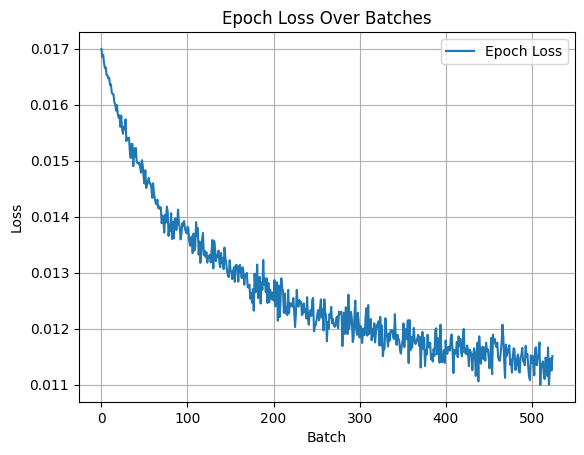

100%|██████████| 5/5 [1:20:21<00:00, 964.22s/it]


In [8]:
train_model(model, train, loss_func, optimizer, num_epochs=5)

In [16]:
a = 1
def add(b):
    b += 1
add(a)
print(a)

1


In [ ]:
def count_labels(loader, arr):
    for batch in loader:
        _, labels = batch
        labels = torch.argmax(labels, dim=1)
        for label in labels:
            l = int(label)
            arr[l] += 1
    print(arr)
    return arr

/Users/jackylei/Documents/Semiconductors/Playground/get_image_dataset.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  label_dist = nn.functional.softmax(nn.functional.one_hot(label_tensor, num_classes=6).to(torch.float32))


[52084, 21000, 0, 0, 0, 0]


In [9]:
def evaluate_model(model, testloader):
    model.eval()
    count = 0.0
    total = 0.0
    for batch in testloader:
        img_patch, label_dist = batch
        label_dist = label_dist.to(model.device)
        preds = model(img_patch.to(model.device))
        label_tensor = torch.argmax(label_dist, dim=1)
        for i in range(len(preds)):
            pred = torch.argmax(preds[i])
            if pred == label_tensor[i]:
                count += 1
            total += 1
    print(f'Accuracy: {count / total} of {total} patches')

In [10]:
evaluate_model(model, test)

Accuracy: 0.7047516942987326 of 26117.0 patches


In [11]:
torch.argmax(torch.randn((50,6)), dim=1).shape

torch.Size([50])

/Users/jackylei/Documents/Semiconductors/Playground/get_image_dataset.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  label_dist = nn.functional.softmax(nn.functional.one_hot(label_tensor, num_classes=6).to(torch.float32))


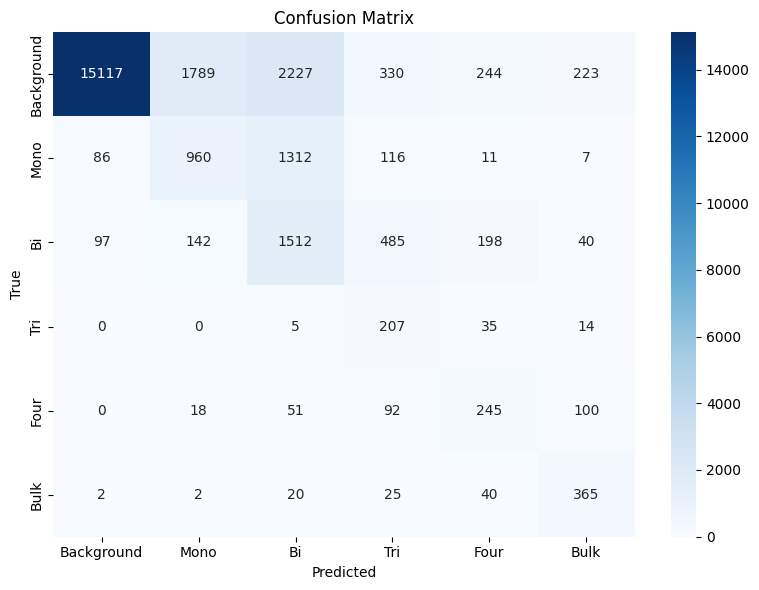

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, dataloader, class_names, device='cpu', normalize=False):
    """
    Computes and plots the confusion matrix for a classification model.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader with (inputs, labels).
        class_names: List of class names.
        device: 'cpu' or 'cuda'.
        normalize: If True, show percentages instead of raw counts.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            img_patch, label = batch
            label = label.to(model.device)
            img_patch = img_patch.to(model.device).to(torch.float32)
            outputs = model(img_patch)
            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            target = torch.argmax(label, dim=1).cpu().numpy()
            all_preds.append(pred)
            all_labels.append(target)

    preds = np.hstack(all_preds)
    labels = np.hstack(all_labels)

    cm = confusion_matrix(labels, preds)
    
    if normalize:
        cm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model, test, class_names=['Background', 'Mono', 'Bi', "Tri", "Four", "Bulk"])

In [15]:
len(train)

116936

In [ ]:
def patch_image(file_path, patch_size):
    width, height = patch_size
    img = Image.open(file_path)
    plt.imshow(img)
    plt.xticks([i for i in range(0,img.size[0], width)])
    plt.yticks([i for i in range(0,img.size[1], height)])
    plt.grid()
    plt.show()
patch_image('../Image Segmentation Data/denoised_quantized/4_MoS2_4.jpg',(12,12))